# Weather Station Clustering 

##K-means using python & scikit-learn¶

Created by: Saeed Aghabozorgi

Environment Canada		  
Monthly Values for July - 2015	  	
		
Legend  		
Stn_Name::::	Station Name  
Lat	    ::::	Latitude (North + , degrees)  
Long	::::	Longitude (West - , degrees)  
Prov	::::	Province  
Tm	    ::::	Mean Temperature (Â°C)  
DwTm	::::	Days without Valid Mean Temperature  
D	    ::::	Mean Temperature difference from Normal (1981-2010) (Â°C)  
Tx	    ::::	Highest Monthly Maximum Temperature (Â°C)  
DwTx	::::	Days without Valid Maximum Temperature  
Tn	    ::::	Lowest Monthly Minimum Temperature (Â°C)  
DwTn	::::	Days without Valid Minimum Temperature  
S	    ::::	Snowfall (cm)  
DwS	    ::::	Days without Valid Snowfall  
S%N	    ::::	Percent of Normal (1981-2010) Snowfall  
P	    ::::	Total Precipitation (mm)  
DwP	    ::::	Days without Valid Precipitation  
P%N	    ::::	Percent of Normal (1981-2010) Precipitation  
S_G  	::::	Snow on the ground at the end of the month (cm)  
Pd	    ::::	Number of days with Precipitation 1.0 mm or more  
BS	    ::::	Bright Sunshine (hours)  
DwBS	::::	Days without Valid Bright Sunshine  
BS%  	::::	Percent of Normal (1981-2010) Bright Sunshine  
HDD 	::::	Degree Days below 18 Â°C  
CDD	    ::::	Degree Days above 18 Â°C  
Stn_No	::::	Climate station identifier (first 3 digits indicate   drainage basin, last 4 characters are for sorting alphabetically).  
NA	    ::::	Not Available  

### 1-Download Data

In [115]:
#!/usr/local/bin/wget -O /resources/weather-stations20140101-20141231.csv https://ibm.box.com/shared/static/mv6g5p1wpmpvzoz6e5zgo47t44q8dvm0.csv

### 2- Load data

In [116]:
import csv
import pandas as pd
import numpy as np
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

filename='/resources/weather-stations20140101-20141231.csv'
# Load and parse the data
data = sc.textFile(filename)

in the following example after loading and parsing data, we use the KMeans object to cluster the data into two clusters. The number of desired clusters is passed to the algorithm. We then compute Within Set Sum of Squared Error (WSSSE). You can reduce this error measure by increasing k. In fact the optimal k is usually one where there is an “elbow” in the WSSSE graph.

### 2- Clean data

#### To filter out the header

In [117]:
header = data.first() #extract header
parsedData = data.filter(lambda x:x !=header) # to filter the headet
parsedData.take(4)

[u'CHEMAINUS,48.935,-123.742,BC,8.2,0,NA,13.5,0,1,0,0,0,NA,178.8,0,NA,0,12,,,NA,273.3,0,1011500',
 u'COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7,0,3,15,0,-3,0,0,0,0,258.6,0,104,0,12,,,NA,307,0,1012040',
 u'LAKE COWICHAN,48.829,-124.052,BC,6.8,13,2.8,16,9,-2.5,9,0,9,NA,264.6,9,NA,,11,,,NA,168.1,0,1012055',
 u'DISCOVERY ISLAND,48.425,-123.226,BC,,,NA,12.5,0,,,,,NA,,,NA,,,,,NA,,,1012475']

#### Prepating feature set
This step includes creating a feature set for each bservation, filtering the rows without temperature value, and coverting the strings values to float

In [118]:
parsedData = parsedData.map(lambda line: array([x for x in line.split(',')])) \
.map(lambda ar: array([(ar[1]),(ar[2]),(ar[4])])) \
.filter(lambda ar: ar[2] !='') \
.map(lambda ar:array([float(ar[0]),float(ar[1]),float(ar[2])]))  # to convet to float
parsedData.take(4)

[array([  48.935, -123.742,    8.2  ]),
 array([  48.824, -124.133,    7.   ]),
 array([  48.829, -124.052,    6.8  ]),
 array([  48.735, -123.728,    7.7  ])]

#### Filtering out outrange Long and Lat

In [131]:
llon = -140
ulon = -50
llat = 40
ulat = 65
parsedData = parsedData.filter(lambda ar: (ar[1] > llon) & (ar[1] < ulon) & (ar[0] > llat) &(ar[0] < ulat))
parsedData.take(4)

[array([  48.935, -123.742,    8.2  ]),
 array([  48.824, -124.133,    7.   ]),
 array([  48.829, -124.052,    6.8  ]),
 array([  48.735, -123.728,    7.7  ])]

#### Scaling
Most machine learning algorithms consider the magnitude of each element in the feature vector, and thus work best when the features are scaled so they weigh equally (e.g., all features have a mean of 0 and standard deviation of 1). Once you have built feature vectors, you can use the StandardScaler class in MLlib to do this scaling, both for the mean and the standard deviation. You create a StandardScaler, call fit() on a dataset to obtain a StandardScalerModel (i.e., compute the mean and variance of each column), and then call transform() on the model to scale a dataset. Ref: Holden Karau, Learning Spark

In [121]:
from pyspark.mllib.feature import StandardScaler
scaler = StandardScaler(withMean=True, withStd=True)
scalerModel = scaler.fit(parsedData)
normalizedData = scalerModel.transform(parsedData)
normalizedData.take(5)

[DenseVector([-0.3043, -1.1678, 1.9691]),
 DenseVector([-0.3295, -1.1847, 1.8468]),
 DenseVector([-0.3284, -1.1812, 1.8264]),
 DenseVector([-0.3498, -1.1672, 1.9181]),
 DenseVector([-0.4188, -1.1548, 2.0302])]

### 3- To build the model
'k' is the number of desired clusters.  
'maxIterations' is the maximum number of iterations to run.  
'initializationMode' specifies either random initialization or initialization via k-means||.  
'runs is the number' of times to run the k-means algorithm.  
'initializationSteps' determines the number of steps in the k-means|| algorithm.  
'epsilon' determines the distance threshold within which we consider k-means to have converged.  
'initialModel' is an optional set of cluster centers used for initialization. If this parameter is supplied, only one run is performed.  


In [134]:
# Build the model (cluster the data)
clusterNum = 7
clusters = KMeans.train(normalizedData, clusterNum, maxIterations=10,
        runs=10, initializationMode="random")
clusters.centers

[array([ 0.00654673, -1.10997195,  1.60259388]),
 array([-1.15535248,  0.91821811, -0.454377  ]),
 array([-0.71496739,  1.56463342,  0.19665454]),
 array([ 0.21413742, -0.14842476, -0.81230601]),
 array([-0.06647772,  1.10111207, -1.0378888 ]),
 array([ 2.30126223, -0.42255842, -1.2796199 ]),
 array([ 0.58449543, -0.77872241,  0.24858836])]

### 4- Prediction of cluster
#### To test the model with a usecase

In [123]:
x= scalerModel.transform(array([48.935, -123.742,-14.2]))
print(x)
clusters.predict(x)

[-0.304278476978,-1.16784760835,-0.313948560566]


3

#### To test the model with training set

In [124]:
normalizedData.take(5)

[DenseVector([-0.3043, -1.1678, 1.9691]),
 DenseVector([-0.3295, -1.1847, 1.8468]),
 DenseVector([-0.3284, -1.1812, 1.8264]),
 DenseVector([-0.3498, -1.1672, 1.9181]),
 DenseVector([-0.4188, -1.1548, 2.0302])]

In [125]:
clust=normalizedData.map(lambda x:clusters.predict(x))
clust.take(5)

[6, 6, 6, 6, 6]

### 5- Evaluation of the model

In [126]:
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

In [127]:
WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 128782.595196


### 6- To save the model

In [128]:
# Save and load model
#clusters.save(sc, "myModelPath")
#sameModel = KMeansModel.load(sc, "myModelPath")

### 7- Visualization of the clusters on map
#### converting RDD to dataframe to visualize clusters

In [129]:
data= parsedData.collect()
labels=clust.collect()
pdf = pd.DataFrame(data)
pdf.columns=['Lat','Long','Tm']
pdf['Clus_km']=labels
pdf.head()

,Lat,Long,Tm,Clus_km
0,48.935,-123.742,8.2,6
1,48.824,-124.133,7.0,6
2,48.829,-124.052,6.8,6
3,48.735,-123.728,7.7,6
4,48.432,-123.439,8.8,6


#### Visualize the clusters using Basemap

Cluster 0, Avg Temp: -20.176875
Cluster 1, Avg Temp: -14.8996478873
Cluster 2, Avg Temp: -18.3875
Cluster 3, Avg Temp: -8.87182539683
Cluster 4, Avg Temp: -13.9131034483
Cluster 5, Avg Temp: -28.0232142857
Cluster 6, Avg Temp: 4.62118644068


/Library/Python/2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


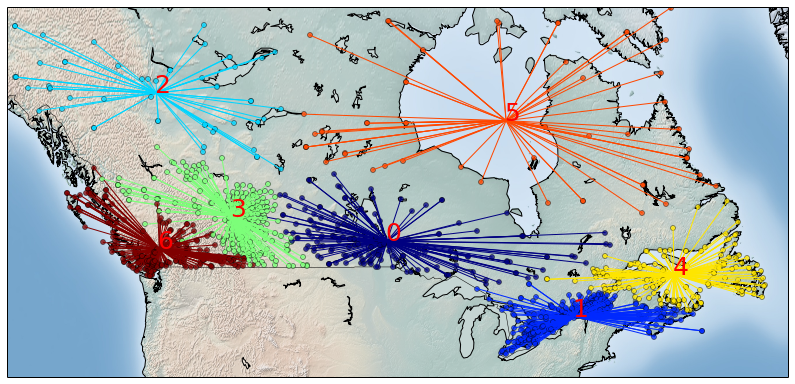

In [186]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)
my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

xs,ys = my_map(np.asarray(pdf['Long']), np.asarray(pdf['Lat']))
pdf['xm'] = xs.tolist()
pdf['ym'] =ys.tolist()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))

for i in range(clusterNum): 
    cluster = pdf[["Tm","xm","ym","Clus_km"]][pdf.Clus_km==i]
    cenx.append(np.mean(cluster.xm)) 
    ceny.append(np.mean(cluster.ym) )
    plt.text(cenx[i],ceny[i],str(i), fontsize=25, color='red',)
    print "Cluster "+str(i)+', Avg Temp: '+ str(np.mean(cluster.Tm))
    
#Visualization1
for index,row in pdf.iterrows():
    my_map.plot(row.xm, row.ym,markerfacecolor =colors[np.float(row.Clus_km)],  marker='o', markersize= 5, alpha = 0.75)
    plt.plot([cenx[int(row.Clus_km)],row.xm], [ceny[int(row.Clus_km)],row.ym],'-',color=colors[np.float(row.Clus_km)] )